In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function

In [33]:
exponential_count =5
parameter_count = exponential_count*2+1

Load a model or creat a new one?

In [34]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [35]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\crpdn\AppData\Local\Temp\ipykernel_4524\431649043.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [36]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:50*10])
df.head()

,Pattern,Time,Current,On time,Off time
500,11/1000,79.005742,1.564,74,155
501,11/1000,79.230081,1.422,74,155
502,11/1000,79.460954,1.329,74,155
503,11/1000,79.690012,1.261,74,155
504,11/1000,79.921769,1.212,74,155


In [37]:
target_points = 50
cutoff_current_min = 0
must_be_growth = False
must_be_decay = False
min_gradient =0
max_final_gradient = 1

Text(0.5, 1.0, 'Data to be modeled')

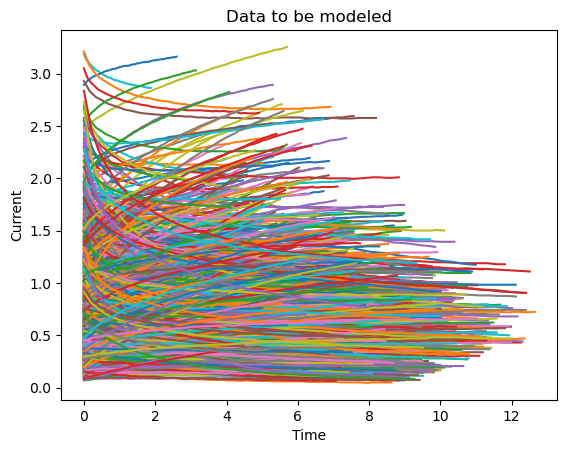

In [38]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
list_of_dfs_fixed = []
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != target_points:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == target_points
    if np.min(y_current)>cutoff_current_min and np.max(np.abs(np.gradient(y_current,y_current.index)))>min_gradient and np.min(np.abs(np.gradient(y_current,y_current.index)[:-10]))<max_final_gradient:
        if must_be_growth:
            if y_current.iloc[0]<y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)
        elif   must_be_decay:
            if y_current.iloc[0]>y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)          
        else:
            plt.plot(x_time, y_current, '-')
            list_of_dfs_fixed.append(data)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [39]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs_fixed),3))
#initialize array of expected shape
y_data = np.zeros((len(list_of_dfs_fixed), points, 2))
prev_on_time = 0
prev_off_time = 0
for i in range(len(list_of_dfs_fixed)):
    data = list_of_dfs_fixed[i]
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != target_points:
        print(points)
        continue
    if np.max(y_current)>cutoff_current_min and prev_on_time !=0:
        label = np.column_stack((x_time,y_current))  
        y_data[i,:,:]= label
        features =  np.array([np.min(y_current.values), data['On time'].iloc[0]-prev_on_time, data['Off time'].iloc[0]-prev_off_time])
        X_data[i,:] = features
    prev_on_time = data['On time'].iloc[0]
    prev_off_time = data['Off time'].iloc[0]

print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")


X shape:(990, 3)
y shape:(990, 50, 2)


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [42]:
import keras

import tensorflow.keras.backend as K

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the specified task.

    Parameters:
    - y_true: Ground truth values, of shape (batch_size, 2, N).
    - y_pred: Predicted values, of shape (batch_size, 7,N).

    Returns:
    - loss: Scalar value representing the mean loss over the batch.
    """

    # Extract x and y values from y_true
    x_values = y_true[:,:,0]  # Shape: (batch_size, N)
    y_values = y_true[:,:,1]  # Shape: (batch_size, N)
    
    function_values = tf.zeros_like(x_values)
    for i in range(int((y_pred.shape[2]-1)/2)):
        temp_val= y_pred[:, :,i] * K.exp(-(x_values) * y_pred[:, :,i+1])
        function_values = function_values+ temp_val
    function_values = function_values+y_pred[:,:,-1]
    
    # square absolute error
    diff = (y_values -function_values) 
    squared_diff = tf.math.square(diff)
    mse = tf.math.reduce_sum(squared_diff, axis=-1)


    slope_comparison = 0.0
    for i in range(y_true.shape[2]-1):
        x_diff = x_values[:,i+1]-x_values[:,i]  
        function_slope = (function_values[:,i+1]-function_values[:,i])/x_diff 
        true_slope= (y_values[:,i+1]-y_values[:,i])/x_diff
        slope_comparison += tf.math.square(true_slope- function_slope)      

    # square relative error
    # diff = (y_values -function_values) / (y_values+0.0001) #K.maximum(y_values, y_values+0.00001)
    # squared_diff = tf.math.square(diff)
    # mse = tf.math.reduce_sum(squared_diff, axis=-1)

    loss = mse #+ slope_comparison
    return loss
 

def create_nn():
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    layers_dense = keras.layers.Dense(10, 'linear')(inputs)
    layers_dense2 = keras.layers.Dense(10, 'linear')(layers_dense)
    layers_dense3 = keras.layers.Dense(20, 'linear')(layers_dense2)
    layers_dense4 = keras.layers.Dense(20, 'linear')(layers_dense3)
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    parameters = keras.layers.Dense(parameter_count)(layers_dense4)
    # Expand parameters to have same shape as y_true
    expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=expanded_parameters, name="current_function_prediction")

In [43]:
if load:
    model = keras.models.load_model(model_path, custom_objects={'custom_loss':custom_loss})
else:
    model = create_nn()

model.summary()


Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 20)                220       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 11)                231       
                                                                 
 repeat_vector (RepeatVecto  (None, 50

In [44]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer=sgd, #'adam'
                  loss=custom_loss)
    


number_of_epochs = 200




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=20, 
                              min_lr=1e-6)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [45]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/200

70/70 - 1s - loss: 107.9881 - val_loss: 2.4969 - lr: 0.0010 - 1s/epoch - 21ms/step
Epoch 2/200
70/70 - 0s - loss: 2.1434 - val_loss: 2.1481 - lr: 0.0010 - 96ms/epoch - 1ms/step
Epoch 3/200
70/70 - 0s - loss: 2.4060 - val_loss: 2.7353 - lr: 0.0010 - 96ms/epoch - 1ms/step
Epoch 4/200
70/70 - 0s - loss: 2.2287 - val_loss: 2.1822 - lr: 0.0010 - 97ms/epoch - 1ms/step
Epoch 5/200
70/70 - 0s - loss: 2.0973 - val_loss: 2.3896 - lr: 0.0010 - 103ms/epoch - 1ms/step
Epoch 6/200
70/70 - 0s - loss: 2.3552 - val_loss: 1.8662 - lr: 0.0010 - 94ms/epoch - 1ms/step
Epoch 7/200
70/70 - 0s - loss: 1.8376 - val_loss: 2.3889 - lr: 0.0010 - 95ms/epoch - 1ms/step
Epoch 8/200
70/70 - 0s - loss: 2.3138 - val_loss: 1.9421 - lr: 0.0010 - 97ms/epoch - 1ms/step
Epoch 9/200
70/70 - 0s - loss: 2.0529 - val_loss: 2.2570 - lr: 0.0010 - 94ms/epoch - 1ms/step
Epoch 10/200
70/70 - 0s - loss: 1.8878 - val_loss: 1.7860 - lr: 0.0010 - 94ms/epoch - 1ms/step
Epoch 11/200
70/70 - 0s - loss: 1.9662 - val_loss: 1.848

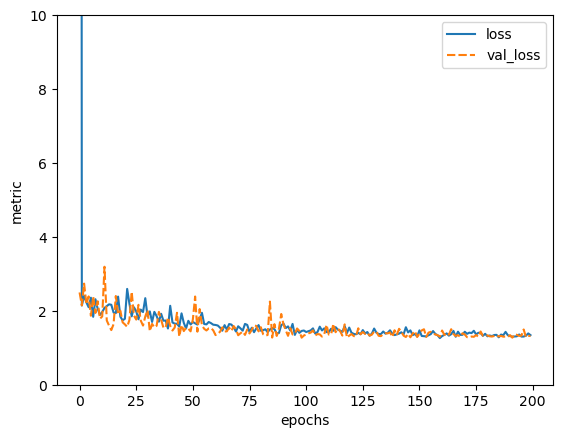

In [46]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'], 10)

In [47]:
# Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')

In [48]:
# make prediction on test data
y_train_prediction = model.predict(X_train)

22/22 [==============================] - 0s 905us/step


5/5 [==============================] - 0s 1ms/step


C:\Users\crpdn\AppData\Local\Temp\ipykernel_4524\3052879839.py:12: RuntimeWarning: invalid value encountered in divide
  plt.plot(y_true[:,0]/np.max(y_true), -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted)), '-', color = 'C0', alpha = 0.3, )


Text(0.5, 1.0, 'Absolute Error of test data prediction')

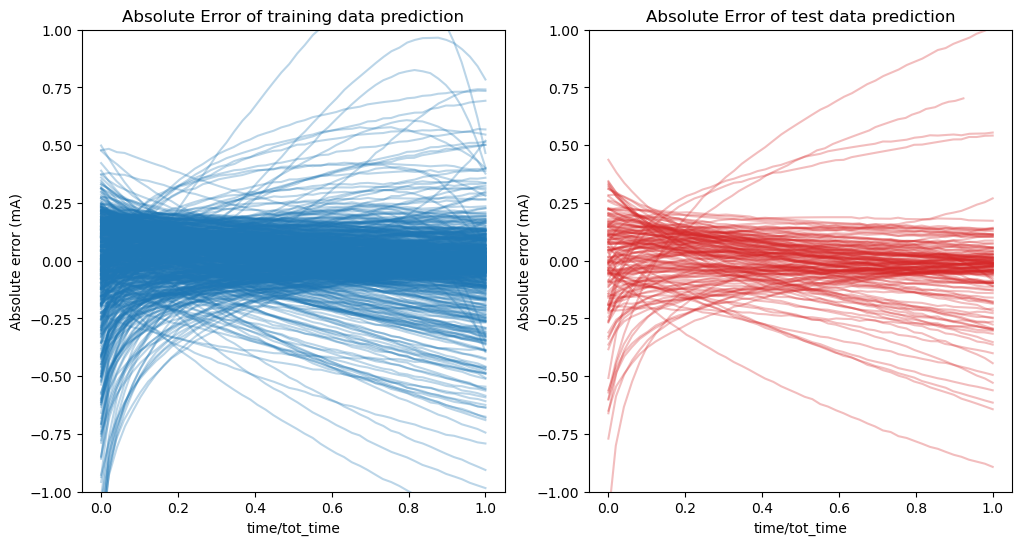

In [49]:
plt.figure(figsize=(12, 6))

y_train_prediction = model.predict(X_train)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
plt.subplot(1, 2, 1)
for test_entry_index in range(X_train.shape[0]):
    # c = next(color)
    y_true = y_train[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted)), '-', color = 'C0', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
    plt.ylim(-1,1)
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of training data prediction')


y_test_prediction = model.predict(X_test)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
plt.subplot(1, 2, 2)
for test_entry_index in range(X_test.shape[0]):
    # c = next(color)
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted)), '-', color = 'C3', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
plt.ylim(-1,1)
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of test data prediction')
# plt.savefig(f"{folder_path}/performance.png")

Relative error plots

5/5 [==============================] - 0s 1ms/step


C:\Users\crpdn\AppData\Local\Temp\ipykernel_4524\2362120252.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(y_true[:,0], -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C0', alpha = 0.3, )


Text(0.5, 1.0, 'Relative Error of test data prediction')

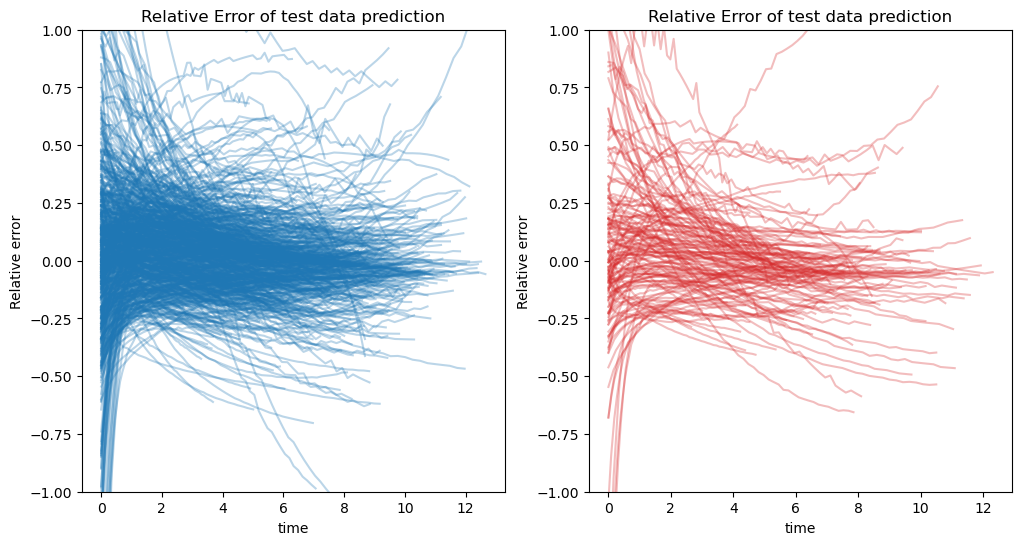

In [50]:
plt.figure(figsize=(12, 6))

y_train_prediction = model.predict(X_train)

plt.subplot(1, 2, 1)
for test_entry_index in range(X_train.shape[0]):
    y_true = y_train[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0], -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C0', alpha = 0.3, )

    plt.ylim(-1,1)
plt.xlabel('time')
plt.ylabel('Relative error')
plt.title('Relative Error of test data prediction')


y_test_prediction = model.predict(X_test)

plt.subplot(1, 2, 2)
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0], -(y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C3', alpha = 0.3, )
    plt.ylim(-1,1)    
plt.xlabel('time')
plt.ylabel('Relative error')
plt.title('Relative Error of test data prediction')

Plot bad predictions

5/5 [==============================] - 0s 1ms/step
33 149


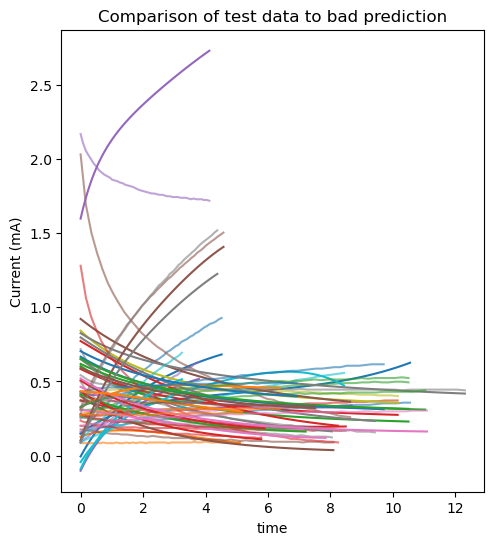

In [51]:
plt.figure(figsize=(12, 6))
y_test_prediction = model.predict(X_test)
plt.subplot(1, 2, 2)
count_total = X_test.shape[0]
count_bad = 0
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    if np.max(np.abs((y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted))/y_true[:,1]))>0.5:
        plt.plot(y_true[:,0], model_function.exponential_function(y_true[:,0], param_predicted), '-', color = f'C{test_entry_index}', alpha = 1, )
        plt.plot(y_true[:,0], y_true[:,1], '-', color = f'C{test_entry_index}', alpha = 0.6, )
        count_bad +=1
          
plt.xlabel('time')
plt.ylabel('Current (mA)')
plt.title('Comparison of test data to bad prediction')
print(count_bad, count_total)

plot good predictions

5/5 [==============================] - 0s 1ms/step
17 149


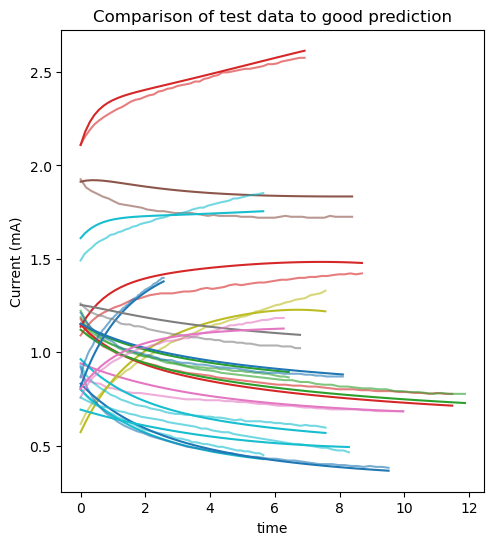

In [52]:
plt.figure(figsize=(12, 6))
y_test_prediction = model.predict(X_test)
plt.subplot(1, 2, 2)
count_total = X_test.shape[0]
count_bad = 0
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    if np.max(np.abs((y_true[:,1]- model_function.exponential_function(y_true[:,0], param_predicted))/y_true[:,1]))<0.1:
        plt.plot(y_true[:,0], model_function.exponential_function(y_true[:,0], param_predicted), '-', color = f'C{test_entry_index}', alpha = 1, )
        plt.plot(y_true[:,0], y_true[:,1], '-', color = f'C{test_entry_index}', alpha = 0.6, )
        count_bad +=1
          
plt.xlabel('time')
plt.ylabel('Current (mA)')
plt.title('Comparison of test data to good prediction')
print(count_bad, count_total)